In [82]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
%matplotlib inline

In [83]:
ps = pd.read_csv('patch_seq_log_mouse.csv')

In [84]:
ps = ps[['Date', 'User', 'Post patch?', 'PCR cycles', 'Resolution index', 'Bad dates']]
ps = ps[ps['PCR cycles'] == 21]
ps['Date'] = pd.to_datetime(ps['Date'], format = '%y%m%d')
ps = ps[ps['Bad dates'] != 'x']
ps = ps.drop('Bad dates', 1)
ps.dropna(subset = ['Post patch?', 'Resolution index'], inplace = True)
ps['Post patch?'] = ps['Post patch?'].astype('category')
ps.head()

,Date,User,Post patch?,PCR cycles,Resolution index
4718,2017-04-19,P2,Outside-Out,21.0,0.787397
4720,2017-04-19,P2,Nucleated,21.0,0.000000
4721,2017-04-19,P2,Outside-Out,21.0,0.322631
4722,2017-04-19,P2,Nucleated,21.0,0.322631
4723,2017-04-19,P2,No-Seal,21.0,0.000000


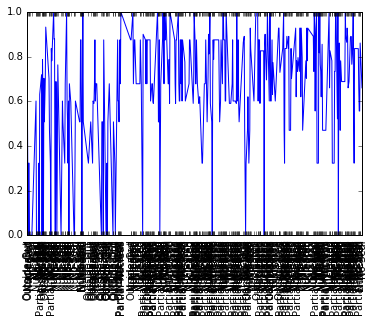

In [80]:
#nu = ps[ps['Post patch?'] == 'Nucleated']
#pn = ps[ps['Post patch?'] == 'Partial-Nucleus']
#oo = ps[ps['Post patch?'] == 'Outside-Out']
#ns = ps[ps['Post patch?'] == 'No-Seal']
#xticks = ps['Post patch?']
#x = ps['Post patch?']
#y = ps['Resolution index']
#plt.scatter(x, y)
#plt.xticks(x,xticks)

ax = ps['Resolution index'].plot()
ax.set_xticks(ps.index)
ax.set_xticklabels(ps['Post patch?'], rotation =90)